In [1]:
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j

In [2]:
time_of_flight = 100 # microseconds
switching_freq = 15/100 # MHz
no_switches = np.floor(time_of_flight*switching_freq)
t_step = time_of_flight*1000/no_switches # ns

physical constants

In [3]:
hbar = cst.hbar
k_B = cst.k
c = cst.c
eps_0 = cst.epsilon_0
gamma = 1/99 # 1/lifetime of the excited state [GHz]
a0 = cst.physical_constants['Bohr radius'][0] # m
q_e = cst.e
r_expval = 0.32*a0
mu_r_expval = 5.22*r_expval

In [7]:
def delta_kr(i,j):
    if i == j:
        return 1
    else:
        return 0

In [88]:
def ThreeJSymbol(j1,m1,j2,m2,j3,m3):
    """
    Purely here for compatibility of direct translation of Konrad's matlab code.
    """
    return float(wigner_3j(j1,j2,j3,m1,m2,m3))

def SixJSymbol(j1,j2,j3,j4,j5,j6):
    """
    Purely here for compatibility of direct translation of Konrad's matlab code.
    """
    return float(wigner_6j(j1,j2,j3,j4,j5,j6))

def NineJSymbol(j1,j2,j3,j4,j5,j6,j7,j8,j9):
    """
    Purely here for compatibility of direct translation of Konrad's matlab code.
    """
    return float(wigner_9j(j1,j2,j3,j4,j5,j6,j7,j8,j9))

In [89]:
def generate_states(J_ground, J_excited, parity):
    """
    P=0 - e, P=1 - f (parity type of the excited state); Ground -> X1Sigma+, Excited B3Pi1
    """
    G = []
    E = []
    for jg in J_ground:
        if jg == 0:
            # (X or B,J,W,F1,F,mF,parity type) 
            G=[[0,0,0,1/2,0,0,0],[0,0,0,1/2,1,-1,0],[0,0,0,1/2,1,0,0],[0,0,0,1/2,1,1,0]] 
        else:
            W = 0
            for F1 in [-1/2, 1/2]:
                for F2 in [-1/2, 1/2]:
                    F = jg+F1+F2
                    for mF in np.arange(-F,F+1):
                        G.append([0,jg,W,jg+F1,F,mF,0])
    for je in J_excited:
        if je == 0:
            # (X or B, J,|W|,F1,F,mF,parity) 
            E=[[1,0,1,1/2,0,0,parity], [1,0,1,1/2,1,-1,parity], [1,0,1,1/2,1,0,parity], [1,0,1,1/2,1,1,parity]]  
        else:
            W = 1
            for F1 in [-1/2,1/2]:
                for F2 in [-1/2,1/2]:
                    F = je+F1+F2
                    for mF in np.arange(-F,F+1):
                        E.append([1,je,W,je+F1,F,mF,parity])
    return G,E

In [90]:
def dipoleHelper(S, Mixing_M, ind):
    st = []
    if S[0] > 0:
        if S[1] == 1:
            for i in range(0,8):
                if Mixing_M[ind, i] != 0:
                    if i == 0:
                        st.append([1, S[2], 1/2, 0, S[5], i])
                    elif i == 1:
                        st.append([1, S[2], 1/2, 1, S[5], i])
                    elif i == 2:
                        st.append([1, S[2], 3/2, 1, S[5], i])
                    elif i == 3:
                        st.append([1, S[2], 3/2, 2, S[5], i])
                    elif i == 4:
                        st.append([2, S[2], 3/2, 1, S[5], i])
                    elif i == 5:
                        st.append([2, S[2], 3/2, 2, S[5], i])
                    elif i == 6:
                        st.append([2, S[2], 5/2, 2, S[5], i])
                    elif i == 8:
                        st.append([3, S[2], 5/2, 2, S[5], i])
        elif S[1] == 2:
            for i in range(0,11):
                if Mixing_M[ind, i] != 0:
                    if i == 0:
                        st.append([1, S[2], 1/2, 1, S[5], i])
                    elif i == 1:
                        st.append([1, S[2], 3/2, 1, S[5], i])
                    elif i == 2:
                        st.append([1, S[2], 3/2, 2, S[5], i])
                    elif i == 3:
                        st.append([2, S[2], 3/2, 1, S[5], i])
                    elif i == 4:
                        st.append([2, S[2], 3/2, 2, S[5], i])
                    elif i == 5:
                        st.append([2, S[2], 5/2, 2, S[5], i])
                    elif i == 6:
                        st.append([2, S[2], 5/2, 3, S[5], i])
                    elif i == 7:
                        st.append([3, S[2], 5/2, 2, S[5], i])
                    elif i == 8:
                        st.append([3, S[2], 5/2, 3, S[5], i])
                    elif i == 9:
                        st.append([3, S[2], 7/2, 3, S[5], i])
                    elif i == 10:
                        st.append([4, S[2], 7/2, 3, S[5], i])
    else:
        st.append([S[1], S[2], S[3], S[4], S[5]])
    return st

In [193]:
def dipoleTransitionMatrixElement(E,G,p,mixing):
    """
    Wtf is p? Konrads code has absolutely no comments anywhere
    """
    if not mixing:
        Je, We, F1e, Fe, Me, Pe = E[1:]
        Jg, Wg, F1g, Fg, Mg, Pg = G[1:]
        
        power = Fe-Me+Fg+F1g+F1e+2*Je-We+3
        parg = (-1)**(Jg+Pg)
        pare = (-1)**(Je+Pe)
        delta = 1-delta_kr(parg,pare)
            
        s = 0
        for q in [-1,0,1]:
            if (Wg != 0) & (We != 0):
                s += ThreeJSymbol(Je,-We,1,q,Jg,Wg)+(-1)**Pe*ThreeJSymbol(Je,We,1,q,Jg,Wg)+(-1)**Pg*ThreeJSymbol(Je,-We,1,q,Jg,-Wg)+(-1)**(Pg+Pe)*ThreeJSymbol(Je,We,1,q,Jg,-Wg)
            elif (Wg == 0) & (We != 0):
                s += np.sqrt(2)*(ThreeJSymbol(Je,-We,1,q,Jg,Wg)+(-1)**Pe*ThreeJSymbol(Je,We,1,q,Jg,Wg))
            elif (Wg != 0) & (We == 0):
                s += np.sqrt(2)*(ThreeJSymbol(Je,-We,1,q,Jg,Wg)+(-1)**Pg*ThreeJSymbol(Je,-We,1,q,Jg,-Wg));
            else:
                s += 2*ThreeJSymbol(Je,-We,1,q,Jg,Wg)
        x = ((-1)**power)*delta*s*np.sqrt((2*Fg+1)*(2*Jg+1)*(2*Fe+1)*(2*Je+1)*(2*F1g+1)*(2*F1e+1)) \
                         *ThreeJSymbol(Fe,-Me,1,p,Fg,Mg) \
                         *SixJSymbol(Jg,F1g,1/2,F1e,Je,1) \
                         *SixJSymbol(F1g,Fg,1/2,Fe,F1e,1)*1/2
    if mixing:
        x = 0
        
        if ((E[0] > 0) & (E[1] == 1)) | ((G[0] > 0) & (G[1] == 1)):
            Mixing_M = np.zeros([4,8])
            Mixing_M[0,:] = [1,0,0,0,0,0,0,0] # E. Norrgard et al.
            Mixing_M[1,:] = [0,0.9996,0.0203,0,0.018,0,0,0]
            Mixing_M[2,:] = [0,0.0267,-0.8519,0,-0.5231,0,0,0]
            Mixing_M[3,:] = [0,0,0,0.8483,0,0.5293,0.0138,0.0064]
        elif ((E[0] > 0) & (E[1] == 2)) | ((G[0] > 0) & (G[1] == 2)):
            Mixing_M = np.zeros([4,11]);  # |J,F1,F>: |1,1/2,1>,|1,3/2,1>,|1,3/2,2>,|2,3/2,1>,|2,3/2,2>,|2,5/2,2>,|2,5/2,3>,|3,5/2,2>,|3,5/2,3>,|3,7/2,3>,|4,7/2,3>
            Mixing_M[0,:] = [-0.0048,-0.5235,0,0.8521,0,0,0,0,0,0,0]
            Mixing_M[1,:] = [0,0,0.5294,0,-0.8483,-0.0011,0,-0.0103,0,0,0]
            Mixing_M[2,:] = [0,0,0.0103,0,0.012,-0.9353,0,-0.3534,0,0,0]
            Mixing_M[3,:] = [0,0,0,0,0,0,0.9342,0,0.3568,0.01,0.0032]
            
        e_ind = 0
        g_ind = 0
        if E[1] == 1:
            if E[3] == 1/2:
                e_ind = 0 if E[4] == 0 else 1
            else:
                e_ind = 2 if E[4] == 1 else 3
        elif E[1] == 2:
            if E[3] == 3/2:
                e_ind = 0 if E[4] == 1 else 1
            else:
                e_ind = 2 if E[4] == 2 else 3

        if G[1] == 1:
            if G[3] == 1/2:
                g_ind = 0 if G[4] == 0 else 1
            else:
                g_ind = 2 if G[4] == 1 else 3
        elif G[1] == 2:
            if G[3] == 3/2:
                g_ind = 0 if G[4] == 1 else 1
            else:
                g_ind = 2 if G[4] == 2 else 3
        
        
        E_st = dipoleHelper(E, Mixing_M, e_ind)
        G_st = dipoleHelper(G, Mixing_M, g_ind)
        
        for i,e_st in enumerate(E_st):
            for j,g_st in enumerate(G_st):
                Je, We, F1e, Fe, Me = e_st[:5]
                Jg, Wg, F1g, Fg, Mg = g_st[:5]
                Pe_mixed = E[6]
                Pg_mixed = E[6]
                                
                Je_mixed = E[1]
                Jg_mixed = G[1]
                
                Pe = Je-Je_mixed+Pe_mixed % 2
                Pg = Jg-Jg_mixed+Pg_mixed % 2

                power = Fe-Me+Fg+F1g+F1e+2*Je-We+3
                parg = (-1)**(Jg_mixed+Pg_mixed)
                pare = (-1)**(Je_mixed+Pe_mixed)
                delta = 1-delta_kr(parg,pare)
                
                if delta == 0:
                    print('delta = 0')
                    continue
                
                s = 0
                for q in [-1,0,1]:
                    if (Wg != 0) & (We != 0):
                        print('1')
                        s += ThreeJSymbol(Je,-We,1,q,Jg,Wg) \
                           + (-1)**Pe*ThreeJSymbol(Je,We,1,q,Jg,Wg) \
                           + (-1)**Pg*ThreeJSymbol(Je,-We,1,q,Jg,-Wg) \
                           + (-1)**(Pg+Pe)*ThreeJSymbol(Je,We,1,q,Jg,-Wg)
                    elif (Wg == 0) & (We != 0):
                        print('2')
                        s += np.sqrt(2)*(ThreeJSymbol(Je,-We,1,q,Jg,Wg) \
                                         + (-1)**Pe*ThreeJSymbol(Je,We,1,q,Jg,Wg))
                    elif (Wg != 0) & (We == 0):
                        print('3')
                        s += np.sqrt(2)*(ThreeJSymbol(Je,-We,1,q,Jg,Wg) \
                                         + (-1)**Pg*ThreeJSymbol(Je,-We,1,q,Jg,-Wg))
                    else:
                        print('4')
                        s += 2*ThreeJSymbol(Je,-We,1,q,Jg,Wg)
                partial_x = ((-1)**power)*delta*s*np.sqrt((2*Fg+1)*(2*Jg+1)*(2*Fe+1)*(2*Je+1)*(2*F1g+1)*(2*F1e+1)) \
                                         *ThreeJSymbol(Fe,-Me,1,p,Fg,Mg) \
                                         *SixJSymbol(Jg,F1g,1/2,F1e,Je,1) \
                                         *SixJSymbol(F1g,Fg,1/2,Fe,F1e,1)*1/2
                print(partial_x)
                
                if (E[0] > 0) & (G[0] == 0):
                    x += partial_x*Mixing_M[e_ind, e_st[5]]
                elif ((E[0] == 0) & (G[0] > 0)):
                    x += partial_x*Mixing_M[g_ind, g_st[5]]
                elif ((E[0] > 0) & (G[0] > 0)):
                    x += partial_x*Mixing_M[g_ind, g_st[5]]*Mixing_M[e_ind, e_st[5]]
                else:
                    x = partial_x
    return x

### states

In [194]:
J_g = [0,1,3]
J_e = [1]

ground_states, excited_states = generate_states(J_g, J_e, 1)

In [195]:
dipoleTransitionMatrixElement(ground_states[3],excited_states[1], p = 1, mixing = True)

3
3
3
0.0 0.408248290463863 -0.3333333333333333
0.0
3
3
3
0.0 -0.408248290463863 -0.16666666666666666
0.0
3
3
3
0.0 0.0 -0.16666666666666666
-0.0


0.0

In [147]:
from itertools import product
for g,e in product(ground_states, excited_states):
    val = dipoleTransitionMatrixElement(e, g, 1, False)
    if val != 0:
        print(f'{val:.2e}')

-4.71e-01
-3.33e-01
4.71e-01
4.71e-01
-1.67e-01
-1.67e-01
4.71e-01
-1.67e-01
-2.89e-01
-4.08e-01
3.33e-01
-1.67e-01
5.89e-01
-1.18e-01
-1.67e-01
5.89e-01
-2.04e-01
-2.89e-01
4.08e-01
2.89e-01
5.00e-01
2.89e-01
2.04e-01
6.12e-01
1.67e-01
1.18e-01
6.12e-01
5.00e-01


In [161]:
from scipy.signal import square

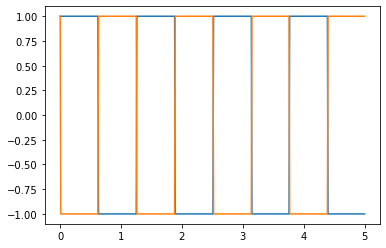

In [171]:
f = 5
t = np.linspace(0,5,501)
plt.plot(t, square(t*f, duty = 0.5))
plt.plot(t, square(-t*f, duty = 0.5))